## Orchestrator-Worker

The **Orchestrator-Worker** pattern is a powerful workflow design where a central "orchestrator" node coordinates multiple "worker" nodes to accomplish complex tasks.

### Why Use This Pattern?
- **Task Decomposition**: Break complex tasks into smaller, specialized subtasks
- **Parallel Execution**: Workers can process subtasks independently
- **Centralized Coordination**: Orchestrator decides which workers to invoke and in what order
- **Flexibility**: Add or remove workers without changing the core logic

### Example Scenario
A research assistant that:
1. **Orchestrator** - Analyzes the query and delegates to appropriate workers
2. **Web Search Worker** - Searches for current information
3. **Code Worker** - Writes or reviews code
4. **Analysis Worker** - Performs data analysis
5. **Report Worker** - Compiles findings into a report

In [18]:
import os
from typing import TypedDict, Annotated, List, Dict, Any
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from dotenv import load_dotenv
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

load_dotenv()
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL")

# Initialize the LLM
llm = ChatOllama(model="minimax-m2.5:cloud", base_url=OLLAMA_BASE_URL)

In [19]:
# Define the State
from langchain_core.messages import AIMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import Tool

class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    next_step: str

In [20]:
# Define Worker Nodes
def search_worker(state: State):
    print("---SEARCH WORKER---")
    # Get the latest user message or relevant context
    last_message = state["messages"][-1]
    query = last_message.content
    
    # Use DuckDuckGo Search
    search = DuckDuckGoSearchRun()
    try:
        results = search.invoke(query)
    except Exception as e:
        results = f"Search failed: {str(e)}"
        
    return {"messages": [AIMessage(content=f"[Search Results] {results}", name="search_worker")]}

def code_worker(state: State):
    print("---CODE WORKER---")
    # In a real scenario, this would use an LLM to generate code based on the context
    return {"messages": [AIMessage(content="[Code] Generated Python code example for a state machine.", name="code_worker")]}

def analysis_worker(state: State):
    print("---ANALYSIS WORKER---")
    # In a real scenario, this would analyze the code or data
    return {"messages": [AIMessage(content="[Analysis] Complexity is O(N) for the proposed solution.", name="analysis_worker")]}

def report_worker(state: State):
    print("---REPORT WORKER---")
    # In a real scenario, this would compile a final report
    return {"messages": [AIMessage(content="[Report] Final report: AI Agents are evolving rapidly...", name="report_worker")]}

In [21]:
import json
import re

# Define the Orchestrator Node
def orchestrator(state: State):
    messages = state["messages"]
    
    # Create a prompt that forces the LLM to choose the next step
    system_message = SystemMessage(content="""You are a workflow orchestrator. 
Your goal is to coordinate a team of workers to complete the user's request.

Available Workers:
- 'search_worker': Retrieves information.
- 'code_worker': Writes code.
- 'analysis_worker': Analyzes data or code.
- 'report_worker': Compiles the final answer.

Instructions:
1. Review the conversation history.
2. Decide which worker is needed next.
3. If the task is fully completed, choose 'finish'.
4. Do not repeat the same worker unnecessarily.
5. You MUST return ONLY a JSON object. Do not add any preamble or explanation.
6. The JSON format must be: {"next_step": "worker_name", "reason": "brief explanation"}
""")
    
    # We invoke the LLM with the system instruction + conversation history
    response = llm.invoke([system_message] + messages)
    
    # Parse the JSON response
    try:
        content = response.content.strip()
        
        # Try to find JSON using regex if direct parsing fails or if wrapped in code blocks
        json_match = re.search(r'\{.*\}', content, re.DOTALL)
        if json_match:
            content = json_match.group(0)
            
        decision = json.loads(content)
        next_step = decision.get("next_step", "finish")
        print(f"Orchestrator Decision: {next_step} ({decision.get('reason', '')})")
    except Exception as e:
        print(f"Error parsing decision: {e}. Output was: {response.content}")
        # Fallback strategy: if the model mentions a worker name, try to use it
        content_lower = response.content.lower()
        if "search" in content_lower:
            next_step = "search_worker"
        elif "code" in content_lower:
            next_step = "code_worker"
        elif "analy" in content_lower:
            next_step = "analysis_worker"
        elif "report" in content_lower:
            next_step = "report_worker"
        else:
            next_step = "finish"
        print(f"Fallback decision: {next_step}")
        
    return {"next_step": next_step}

In [22]:
# Build the Graph
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("orchestrator", orchestrator)
workflow.add_node("search_worker", search_worker)
workflow.add_node("code_worker", code_worker)
workflow.add_node("analysis_worker", analysis_worker)
workflow.add_node("report_worker", report_worker)

# Add Edges
workflow.add_edge(START, "orchestrator")

# Add Conditional Edges from Orchestrator
workflow.add_conditional_edges(
    "orchestrator",
    lambda state: state["next_step"],
    {
        "search_worker": "search_worker",
        "code_worker": "code_worker",
        "analysis_worker": "analysis_worker",
        "report_worker": "report_worker",
        "finish": END
    }
)

# Return to Orchestrator after each worker finishes
workflow.add_edge("search_worker", "orchestrator")
workflow.add_edge("code_worker", "orchestrator")
workflow.add_edge("analysis_worker", "orchestrator")
workflow.add_edge("report_worker", "orchestrator")

# Compile
app = workflow.compile()

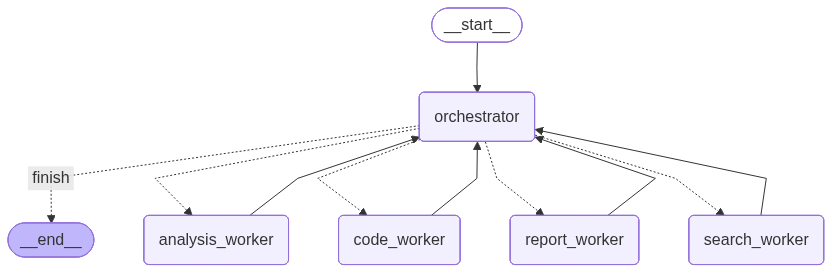

In [23]:
# Visualize
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# Run the Orchestrator
# We ask for a complex task that might require multiple workers
request = "Find info on the latest LLM agent patterns, write a mock python script for it, analyze the script complexity, and summarize everything in a report."

inputs = {"messages": [HumanMessage(content=request)]}

for event in app.stream(inputs):
    # The stream returns a dictionary with the node name as key and its output as value
    pass